<a href="https://colab.research.google.com/github/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/pytorch_3_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" style="padding-right:10px;" src ="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/university_oviedo_logo.png" width=300 px>

This notebook is from the Course "***Computer vision in the new era of Artificial Intelligence and Deep Learning***", or "*Visión por computador en la nueva era de la Inteligencia Artificial y el Deep Learning*" (ES) from the "Second quarter university extension courses" that the University of Oviedo is offering (05/04/2021 - 16/04/2021)

<[Github Repository](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course) | [Course Web Page Information](https://www.uniovi.es/estudios/extension/cursos2c/-/asset_publisher/SEp0PJi4ISGo/content/vision-por-computador-en-la-nueva-era-de-la-inteligencia-artificial-y-el-deep-learning?redirect=%2Festudios%2Fextension%2Fcursos2c)>

# Neural networks: multilayer perceptron and convolutional network
Neural networks are complex compound functions that are used to create models that relate inputs and outputs.

Traditionally, a neural network is inspired by the biological model of a neuron, where each neuron is approximated by the following function:

$ y = f (x_1 w_1 + x_2 ∗ w_2 + b) $

where $ x_i $ are inputs, $ w_i $ are the weights, b is the bias, and $ f $ is a non-linear function.

The most common way to define neural networks is by combining many neurons following an architecture called multilayer perceptron. This type of network is defined, depending on the problem, with a certain number of inputs and outputs. Depending on the complexity of the problem, a certain number of layers and neurons are configured.

Different configurations can be tested with [TensorFlow Playground](https://playground.tensorflow.org).

For the complex case, you need [a hard-to-find hyperparameter setting](https://playground.tensorflow.org/#activation=relu&regularization=L2&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0.001&noise=0&networkShape=7,7,7,7,7,7&seed=0.40556&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).



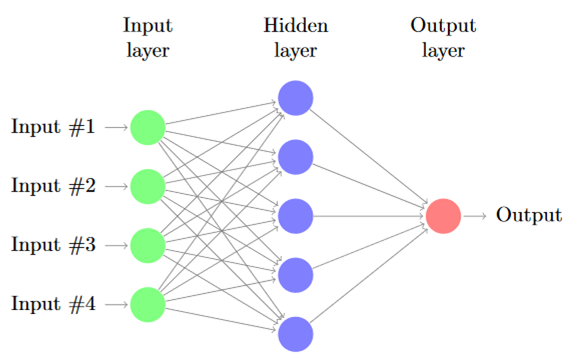

# Digit classification

To understand how to apply a neural network to a classification problem, a classic problem will be used: the classification of digits.

## Dataset

Along with PyTorch, the TorchVision library is distributed, which contains a set of utilities, models and datasets for working with neural networks.

Libraries are imported initially.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

GPU is selected if available.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

The digit dataset can be downloaded using torchvision.

In [ ]:
batch_size = 100

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

The dataset is called MNIST, which after download is transformed into a tensor. The `DataLoader` class is responsible for loading the dataset in batches (groups of images). Each batch is then used to perform training using gradient descent.

After downloading, some local files appear.

In [ ]:
!ls data/MNIST/

processed  raw


In [ ]:
!ls data/MNIST/processed

test.pt  training.pt


One part will be used to train the model and another part to evaluate the model.

Each image of the model can be viewed.

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def ShowSample(i):
  img, label = train_dataset[i]
  img = img.squeeze()
  plt.imshow(img)
  plt.gray()
  plt.title(f'Label: {label}')

interact(ShowSample, i=(0,len(train_dataset)-1));

interactive(children=(IntSlider(value=29999, description='i', max=59999), Output()), _dom_classes=('widget-int…

You can see the images in a grid.

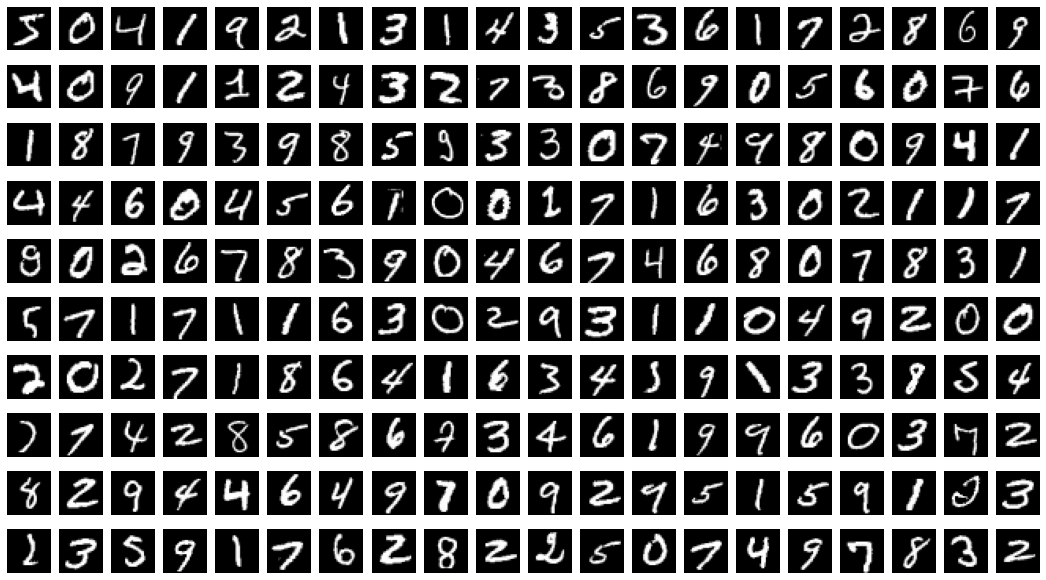

In [ ]:
rows = 10
cols = 20

for i in range(rows):
  for j in range(cols):
    plt.subplot(rows,cols,1 + i*cols + j)
    sample=train_dataset[i*cols + j]
    img = sample[0]
    img = img.squeeze()
    plt.imshow(img)
    plt.gray()
    plt.axis('off')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

A histogram can be made with the number of digits of each type.

Num labels: 10


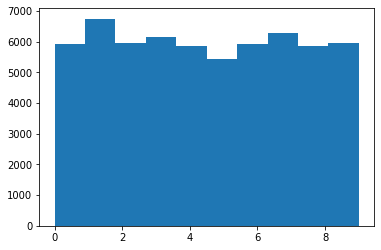

In [ ]:
all_labels = []
for i  in range(len(train_dataset)):
  _, label = train_dataset[i]
  all_labels.append(label)
plt.hist(all_labels)

num_labels = len(set(all_labels))
print(f'Num labels: {num_labels}')

The image loader allows images to be loaded in groups. Then the training process can iterate over them.

Image shape: torch.Size([100, 1, 28, 28])
Labels shape: torch.Size([100])


784

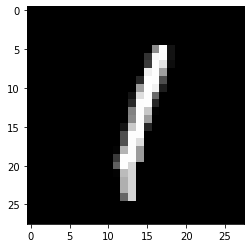

In [ ]:
import matplotlib.pyplot as plt

for i, (images, labels) in enumerate(train_loader): 
  if i == 3:
    plt.imshow(images[0,0,:,:])
    break
print(f'Image shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

images_size = images.shape
num_pixels_per_image = images_size[2]*images_size[3]
num_pixels_per_image

A `torch.Size ([100, 1, 28, 28])` size indicates that there are 100 1-channel images of size 28x28

## Classification using a multilayer perceptron



As the first model, a perceptron will be created with a hidden layer of configurable size. The number of inputs will be equal to the number of pixels in each image and the outputs will be the number of classes.

In [ ]:
num_classes = num_labels
input_size = num_pixels_per_image

The model is defined.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

The training function is defined.

In [ ]:
def train_model(model, criterion, optimizer):
  # Train the model
  total_step = len(train_loader)
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):  
          # Move tensors to the configured device
          images = images.reshape(-1, num_pixels_per_image).to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if (i+1) % 100 == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss}')

The evaluation function is defined.

In [ ]:
def eval_model(model):
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, num_pixels_per_image).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Finally, the hyperparameters are configured, the loss function and the optimizer are defined, the training is carried out and the model is evaluated. In this case a `CrossEntropyLoss` loss function is used, which is appropriate when interpreting the outputs as the probability of belonging to a class.

In [ ]:
# Hyperparameters
hidden_size = 50
num_epochs = 2
learning_rate = 0.001

# Model
model = MLP(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train
train_model(model, criterion, optimizer)

# Eval
eval_model(model)

Epoch [1/2], Step [100/600], Loss: 0.5444229245185852
Epoch [1/2], Step [200/600], Loss: 0.4509945809841156
Epoch [1/2], Step [300/600], Loss: 0.33270490169525146
Epoch [1/2], Step [400/600], Loss: 0.33111295104026794
Epoch [1/2], Step [500/600], Loss: 0.14896085858345032
Epoch [1/2], Step [600/600], Loss: 0.21430324018001556
Epoch [2/2], Step [100/600], Loss: 0.3220707178115845
Epoch [2/2], Step [200/600], Loss: 0.14154954254627228
Epoch [2/2], Step [300/600], Loss: 0.2534041702747345
Epoch [2/2], Step [400/600], Loss: 0.13908806443214417
Epoch [2/2], Step [500/600], Loss: 0.12451659888029099
Epoch [2/2], Step [600/600], Loss: 0.2027970850467682
Accuracy of the network on the 10000 test images: 94.39 %


You can evaluate the model for each image. The Softmax function normalizes the outputs to be interpreted as a probability.

In [ ]:
def softmax(x):
  return torch.exp(x) / torch.exp(x).sum()

def ShowSample(i):
  img, label = test_dataset[i]
  input = img.to(device)
  input = input.reshape(-1, num_pixels_per_image)
  outputs = model(input)
  outputs = softmax(outputs)
  score, prediction = torch.max(outputs.data, 1)
  img = img.squeeze()
  plt.imshow(img)
  plt.gray()
  plt.title(f'Label: {label}, Prediction: {prediction.item()}, Score: {score.item()}')

interact(ShowSample, i=(0,len(test_dataset)-1));

interactive(children=(IntSlider(value=4999, description='i', max=9999), Output()), _dom_classes=('widget-inter…

## Classification using a convolutional neural network (CNN)

We are now going to change the model. In this case a convolutional network will be used. This type of network has the advantage that it takes into account the neighborhood of the pixels. They are also invariant to rotation or translation.

CNNs are based on the [convolution operation](https://en.wikipedia.org/wiki/Kernel_ (image_processing)). [This operation in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is applied to tensors with organization (N, Cin, H, W).

You can see an [animation](https://i.stack.imgur.com/Tnfmi.gif) of the convolution.



The following shows the result of applying this operation to a single image.

In [ ]:
it = iter(train_loader)
first_batch_images,first_batch_labels = next(it)

print(f'Batch size: {first_batch_images.shape}')
one_image = first_batch_images[0,0,:,:]
one_image = one_image.unsqueeze(0)
one_image = one_image.unsqueeze(0)
print(f'Tensor for one image: {one_image.shape}')

# in_channels = 1
# out_channels = 16
step1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
out1 = step1(one_image)
print(f'Conv2d result: {out1.shape}')


Batch size: torch.Size([100, 1, 28, 28])
Tensor for one image: torch.Size([1, 1, 28, 28])
Conv2d result: torch.Size([1, 16, 28, 28])


As a non-linear transformation, the function [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) is commonly used.

In [ ]:
step2 = nn.ReLU()
out2 = step2(out1)
print(f'ReLU result: {out2.shape}')

ReLU result: torch.Size([1, 16, 28, 28])


Next, it is common to use a [MaxPool2d function](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling).

In [ ]:
step3 = nn.MaxPool2d(kernel_size=2, stride=2)
out3 = step3(out2)
print(f'MaxPool2d result: {out3.shape}')

MaxPool2d result: torch.Size([1, 16, 14, 14])


A convolutional neural network fundamentally repeats these three stages in a set of layers. Here is an example.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

The training function is defined.

In [ ]:
def train_model(model, criterion, optimizer):
  total_step = len(train_loader)
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if (i+1) % 100 == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss}')

The evaluation function is defined.

In [ ]:
def eval_model(model):
  model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))  

Finally, training is performed.

In [ ]:
# Hyperparameters
num_epochs = 2
learning_rate = 0.001

# Model
model = CNN(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
train_model(model, criterion, optimizer)

# Eval
eval_model(model)

Epoch [1/2], Step [100/600], Loss: 0.5425857305526733
Epoch [1/2], Step [200/600], Loss: 0.19343438744544983
Epoch [1/2], Step [300/600], Loss: 0.16455723345279694
Epoch [1/2], Step [400/600], Loss: 0.09193937480449677
Epoch [1/2], Step [500/600], Loss: 0.12606820464134216
Epoch [1/2], Step [600/600], Loss: 0.17239384353160858
Epoch [2/2], Step [100/600], Loss: 0.15657538175582886
Epoch [2/2], Step [200/600], Loss: 0.07304256409406662
Epoch [2/2], Step [300/600], Loss: 0.13033033907413483
Epoch [2/2], Step [400/600], Loss: 0.12367206811904907
Epoch [2/2], Step [500/600], Loss: 0.06687664240598679
Epoch [2/2], Step [600/600], Loss: 0.011033712886273861
Test Accuracy of the model on the 10000 test images: 98.22 %


We can analyze the results.

In [ ]:
def softmax(x):
  return torch.exp(x) / torch.exp(x).sum()

def ShowSample(i):
  img, label = test_dataset[i]
  input = img.to(device)
  input = input.unsqueeze(0)
  outputs = model(input)
  outputs = softmax(outputs)
  score, prediction = torch.max(outputs.data, 1)
  img = img.squeeze()
  plt.imshow(img)
  plt.gray()
  plt.title(f'Label: {label}, Prediction: {prediction.item()}, Score: {score.item()}')

interact(ShowSample, i=(0,len(test_dataset)-1));

interactive(children=(IntSlider(value=4999, description='i', max=9999), Output()), _dom_classes=('widget-inter…

More complex CNNs can be found in [this tutorial](https://github.com/yunjey/pytorch-tutorial).